# Convolutional Neural Networks - Solutions

<hr style="clear:both">

This notebook is part of a series of exercises for the CIVIL-226 Introduction to Machine Learning for Engineers course at EPFL and adapted for the ME-390. Copyright (c) 2021 [VITA](https://www.epfl.ch/labs/vita/) lab at EPFL  
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** David Mizrahi

**Adapted by:** Sabri El Amrani
<hr style="clear:both">



In this exercise, we'll build on what was done in the previous exercise and implement Convolutional Neural Nets with PyTorch.

__Recommendation:__ in the toolbox at the top-left of your screen go to Runtime -> Change runtime type. If possible, select a GPU or TPU. Your trainings should run faster this way.

*Run next cell to show tweet*

In [ ]:
%%html
<blockquote class="twitter-tweet" data-lang="en" data-dnt="true"><p lang="en" dir="ltr">A demo from 1993 of 32-year-old Yann LeCun showing off the world&#39;s first convolutional network for text recognition. <a href="https://twitter.com/hashtag/tbt?src=hash&amp;ref_src=twsrc%5Etfw">#tbt</a> <a href="https://twitter.com/hashtag/ML?src=hash&amp;ref_src=twsrc%5Etfw">#ML</a> <a href="https://twitter.com/hashtag/neuralnetworks?src=hash&amp;ref_src=twsrc%5Etfw">#neuralnetworks</a> <a href="https://twitter.com/hashtag/CNNs?src=hash&amp;ref_src=twsrc%5Etfw">#CNNs</a> <a href="https://twitter.com/hashtag/MachineLearning?src=hash&amp;ref_src=twsrc%5Etfw">#MachineLearning</a> <a href="https://t.co/9eeibjJ4MK">pic.twitter.com/9eeibjJ4MK</a></p>&mdash; MIT CSAIL #AAAI2021 (@MIT_CSAIL) <a href="https://twitter.com/MIT_CSAIL/status/1347237563342340097?ref_src=twsrc%5Etfw">January 7, 2021</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>

#### For Google Colab
You can run this notebook in Google Colab using the following link:
https://colab.research.google.com/github/SYCAMORE-Lab/ME390-2024/blob/main/Exercises/09-conv-nets-bonus/convnets.ipynb

Note: Running this exercise on Google Colab instead of Noto will be much faster since you can use GPUs for the computation

In [2]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    # Install torchsummary
    !pip install torchsummary
    # Installations for gmaps interface
    !pip install folium geopandas opencv-python tensorflow
    # Clone the entire repo to access the files
    !git clone -l -s https://github.com/SYCAMORE-Lab/ME390-2024.git cloned-repo
    %cd cloned-repo/Exercises/09-conv-nets-bonus
else:
    # torchsummary
    import sys
    !{sys.executable} -m pip install torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


## 0. Introduction


Today we will be working with the [EuroSAT dataset](https://www.researchgate.net/publication/319463676_EuroSAT_A_Novel_Dataset_and_Deep_Learning_Benchmark_for_Land_Use_and_Land_Cover_Classification), a compilation of 27,000 labeled and geo-referenced images, categorized into 10 distinct classes.

*__Background:__
You are a data scientist working for a leading environmental research organization, specializing in land use and land cover analysis. Your team has compiled a dataset that includes high-resolution Sentinel-2 satellite images, which are part of the Copernicus Earth observation program and are openly and freely accessible. Your task is to develop a predictive model that can accurately classify land use and land cover types based on these satellite images.
The classification system developed through this research could be used to detect land use and land cover changes over time, assisting in the improvement of geographical maps and contributing to more effective environmental monitoring and management.*

## 1. Imports & set-up

This part is nearly identical to last exercise on fully-connected neural networks.

More specifically, we define:

- the EuroSAT dataset & dataloader
- the training & test loop
- a 3-layer fully connected neural net (now called `three_layer_net` instead of `model`)

Then this neural net is trained for 10 epochs. This time, we use **Adam instead of SGD** as our optimizer.

In [4]:
# PyTorch & torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

# Progress bar
from tqdm.auto import tqdm

# torchsummary
import torchsummary

# Helper files
import helpers
import metrics

In [ ]:
torch.__version__

'2.3.1+cu121'

In [ ]:
torchvision.__version__

'0.18.1+cu121'

As was done in last exercise, here is a brief description of these imported packages:

**PyTorch:**
- `torch.nn` Contains the basic building blocks to implement neural nets (incl. different types of layers and loss functions) | [Documentation](https://pytorch.org/docs/stable/nn.html)
- `torch.nn.functional` A functional (stateless) approach to torch.nn, often used for stateless objects (e.g. ReLU) | [Documentation](https://pytorch.org/docs/stable/nn.functional.html) | [More info](https://discuss.pytorch.org/t/what-is-the-difference-between-torch-nn-and-torch-nn-functional/33597/2)
- `torch.optim` A package implementing various optimization algorithms, such as SGD and Adam | [Documentation](https://pytorch.org/docs/stable/optim.html)

**torchvision:**
- `torchvision.transforms` Common image transformations
- `torchvision.datasets` Popular image datasets

**`torchsummary`:** Provides additional information on network architecture

**`tqdm`:** Popular package used to show progress bars | [Documentation](https://tqdm.github.io/)

**`helpers`**: Contains functions to help visualize data and predictions

**`metrics`:** Contains two simple classes that help keep track and compute the loss and accuracy over a training epoch

### Dataset & dataloader

Let's start by preparing the EuroSAT dataset, fetched online.

In [ ]:
from torch.utils.data import Dataset
from torchvision.datasets import ImageFolder
from torchvision.datasets.folder import default_loader
from torchvision.datasets.utils import check_integrity, download_and_extract_archive

URL = "http://madm.dfki.de/files/sentinel/EuroSAT.zip" # URL where the EuroSAT dataset can be downloaded
MD5 = "c8fa014336c82ac7804f0398fcb19387" # MD5 checksum for verifying the integrity of the downloaded file
SUBDIR = '2750'


def random_split(dataset, ratio=0.9, random_state=None):
    if random_state is not None:
        state = torch.random.get_rng_state()
        torch.random.manual_seed(random_state)
    n = int(len(dataset) * ratio)
    split = torch.utils.data.random_split(dataset, [n, len(dataset) - n])
    if random_state is not None:
        torch.random.set_rng_state(state)
    return split


class EuroSAT(ImageFolder):

    classes = [
        "0 - AnnualCrop",
        "1 - Forest",
        "2 - HerbaceousVegetation",
        "3 - Highway",
        "4 - Industrial",
        "5 - Pasture",
        "6 - PermanentCrop",
        "7 - Residential",
        "8 - River",
        "9 - SeaLake",
    ]

    def __init__(self, root='data', transform=None, target_transform=None):
        self.download(root)
        root = os.path.join(root, SUBDIR)
        super().__init__(root, transform=transform, target_transform=target_transform)

    @staticmethod
    def download(root):
        if not check_integrity(os.path.join(root, "EuroSAT.zip")):
            download_and_extract_archive(URL, root, md5=MD5)

In [ ]:
import os

dataset = EuroSAT(
    transform=transforms.Compose(
        [
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.ToTensor(),
        ]
    )
)


100%|██████████| 94280567/94280567 [00:05<00:00, 16407507.55it/s]


Extracting data/EuroSAT.zip to data


Let's check the various class labels with their associated number.

In [ ]:
{i: class_name for i, class_name in enumerate(dataset.classes)}

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

Time to split into training/test set. Note that given the higher nunber of samples in the dataset (27,000), a 90%/10% is quite reasonable (we already have 2,700 test cases this way).

In [ ]:
train_data, test_data = random_split(dataset, 0.9, random_state=42)

In [ ]:
print(f"Images in training data: {len(train_data)}")
print(f"Images in test data: {len(test_data)}")

Images in training data: 24300
Images in test data: 2700


Let's visualize a sample of our dataset.

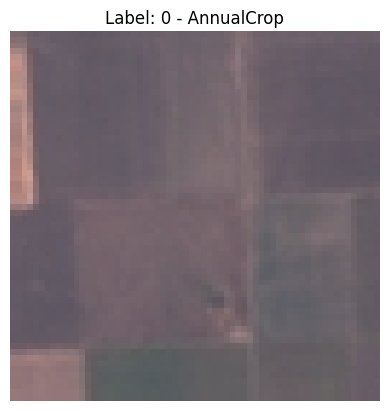

In [ ]:
import matplotlib.pyplot as plt

# Get the first element from the dataset
first_image, first_label = dataset[0]

# To print, convert the tensor back to an image using PIL
# and display it
image = transforms.ToPILImage()(first_image)
plt.imshow(image)
plt.title(f"Label: {first_label} - {dataset.classes[first_label]}")
plt.axis('off')
plt.show()

We can now prepare the dataloader, built on top of the dataset.

In [ ]:
batch_size = 32
# Reshuffle training data at every epoch, but not the test data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Time now to visualize a batch.

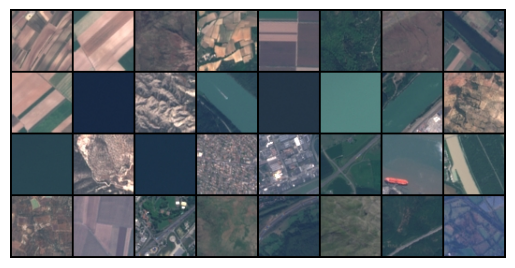

tensor([[6, 0, 2, 6, 0, 1, 2, 8],
        [0, 9, 2, 8, 9, 9, 8, 6],
        [9, 2, 9, 7, 4, 3, 9, 8],
        [6, 0, 3, 2, 3, 2, 3, 5]])


In [ ]:
images, targets = next(iter(train_loader))
helpers.imshow(torchvision.utils.make_grid(images, nrow=8))
print(targets.reshape(-1, 8))

### Training loop & test accuracy

We are now ready for training/testing. Note how the functions below are very similar to the ones we used in the previous notebook on neural networks.

In [ ]:
def train(model: torch.nn.Module, train_loader: torch.utils.data.DataLoader, loss_fn: torch.nn.Module, optimizer: torch.optim.Optimizer, epochs: int):

    # Initialize metrics for loss and accuracy
    loss_metric = metrics.LossMetric()
    acc_metric = metrics.AccuracyMetric(k=1)

    model.train()

    for epoch in range(1, epochs + 1):

        # Progress bar set-up
        pbar = tqdm(total=len(train_loader), leave=True)
        pbar.set_description(f"Epoch {epoch}")

        # Iterate through data
        for data, target in train_loader:

            # Zero-out the gradients
            optimizer.zero_grad()

            # Forward pass
            out = model(data)

            # Compute loss
            loss = loss_fn(out, target)

            # Backward pass
            loss.backward()

            # Optimizer step
            optimizer.step()

            # Update metrics & progress bar
            loss_metric.update(loss.item(), data.shape[0])
            acc_metric.update(out, target)
            pbar.update()

        # End of epoch, show loss and acc
        pbar.set_postfix_str(f"Train loss: {loss_metric.compute():.3f} | Train acc: {acc_metric.compute() * 100:.2f}%")
        loss_metric.reset()
        acc_metric.reset()

def test(model: torch.nn.Module, dataloader: torch.utils.data.DataLoader):

    # Initialize accuracy metric
    acc_metric = metrics.AccuracyMetric(k=1)

    # Progress bar set-up
    pbar = tqdm(total=len(test_loader), leave=True)

    model.eval()

    with torch.no_grad():
        # Iterate through data
        for data, target in dataloader:

            # Forward pass
            out = model(data)

            # Update accuracy metric
            acc_metric.update(out, target)

            # Update progress bar
            pbar.update()

    # End of epoch, show loss and acc
    test_acc = acc_metric.compute() * 100
    pbar.set_postfix_str(f"Acc: {test_acc:.2f}%")
    print(f"Accuracy is {test_acc:.2f}%")

### Three layer fully-connected NN

We can now build a first model for classification using fully-connected neural networks, similar to the previous notebook. Note the only difference: the imput image needs to be flattened to a one-dimensional vector of dimension

In [ ]:
class ThreeLayerNet(nn.Module):
    """3-Layer neural net"""

    def __init__(self) -> None:
        super().__init__()
        self.fc1 = nn.Linear(12288, 1000)
        self.fc2 = nn.Linear(1000, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Flatten to get tensor of shape (batch_size, 784)
        x = x.flatten(start_dim=1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)

# Note: Instance is called three_layer_net instead of model this time around
three_layer_net = ThreeLayerNet()

#### Loss & optimizer

As before, we'll use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) loss for classification.

However, this time, we'll switch up optimizers and use **[Adam](https://pytorch.org/docs/master/generated/torch.optim.Adam.html)** with the default settings for the learning rate and momentum. This should help us get faster convergence than with SGD.

Implement both the loss and the optimizer in the next cell.

In [ ]:
### START CODE HERE ###
# Cross-Entropy loss
loss_fn = nn.CrossEntropyLoss()
# Use Adam with default parameters
optimizer = optim.Adam(three_layer_net.parameters())
### END CODE HERE ###

####  Training

In [ ]:
train(three_layer_net, train_loader, loss_fn, optimizer, epochs=5)

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

####  Testing

In [ ]:
test(three_layer_net, test_loader)

  0%|          | 0/85 [00:00<?, ?it/s]

Accuracy is 47.11%


####  Saving

In [67]:
torch.save(three_layer_net, 'three_layer_net.pt')

**Expected result:** approximately 45% test accuracy

## 2. LeNet

In this part, you'll see the implementation of a slightly modified version of LeNet5, a convolutional neural network proposed by [Yann Le Cun et al. in 1998](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). LeNet was one of the earliest convolutional neural networks, and helped promote the development of deep learning. Your goal is to reproduce this network architecture from just the paper's figure (see below) and a few extra tips.

#### LeNet5

<img src="https://github.com/SYCAMORE-Lab/ME390-2023-Students/blob/main/Exercises/07-convnets/images/lenet.png?raw=1" width=900></img>

Here are some tips to understand implementation:

- Add a padding of 2 in the first convolution layer. __Hint:__`nn.Conv2d` has a padding parameter
- Both convolutional layers use 5x5 filters with stride 1
- Adapt the convolutions knowing that our input images has a dimension of 3x64x64 (the 3 channels are there because we are dealing with colored RGB images). The first convolution should output 18 channels, and the second convolution 54 channels
- We use ReLU as the activation function
- We use Max-Pooling whenever subsampling is needed
- We'll need to flatten the tensor at some point
- Adapt the input size of the fully connected layer accordingly (check the formula seen in class for the size of the output of a convolution layer)
- As before, no need to add softmax after the final layer, `nn.CrossEntropyLoss()` adds it automatically

Furthermore, here is some helpful documentation:
- [`torch.nn` documentation](https://pytorch.org/docs/stable/nn.html)
- [`torch.nn.functional` documentation](https://pytorch.org/docs/stable/nn.functional.html)

In [6]:
class LeNet(nn.Module):
    """LeNet5 adapted for input images of shape 3x64x64"""

    def __init__(self) -> None:
        super().__init__()
        ### START CODE HERE ###
        # Hint: Initialize two 2D convolutions and three linear layers
        self.conv1 = nn.Conv2d(3, 18, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(18, 54, kernel_size=5)
        self.fc1 = nn.Linear(54 * 14 * 14, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        ### END CODE HERE ###

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ### START CODE HERE ###
        # Apply two convolutions with relu activations, and two 2D max poolings
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        ### END CODE HERE ###
        x = x.flatten(start_dim=1) # Flattening before applying feedforward layers
        ### START CODE HERE ###
        # You need two relu layers and the output layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        out = self.fc3(x)
        return out
        ### END CODE HERE ###

    def predict(self, x: torch.Tensor) -> torch.Tensor:
        """Predicts classes by calculating the softmax"""
        logits = self.forward(x)
        return F.softmax(logits, dim=1)


lenet = LeNet()

In [ ]:
# Check that a forward pass gives the correct output size
print(lenet(images).shape)

torch.Size([32, 10])


**Expected output:** `torch.Size([32, 10])`

Initialize the Cross-entropy loss function and the Adam optimizer with default paramters.

In [ ]:
### START CODE HERE ###
# Cross-Entropy loss
loss_fn = nn.CrossEntropyLoss()
# Adam
optimizer = optim.Adam(lenet.parameters())
### END CODE HERE ###

####  Training

In [ ]:
### START CODE HERE ###
# Train the model
train(lenet, train_loader, loss_fn, optimizer, epochs=5)
### END CODE HERE ###

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

  0%|          | 0/760 [00:00<?, ?it/s]

####  Testing

In [ ]:
### START CODE HERE ###
# Test the model
test(lenet, test_loader)
### END CODE HERE ###

  0%|          | 0/85 [00:00<?, ?it/s]

Accuracy is 75.15%


**Expected result:** approximately 75% test accuracy

#### Visualizing predictions

Let's visualize some of these predictions with the help of `view_prediction()` from `helpers`.

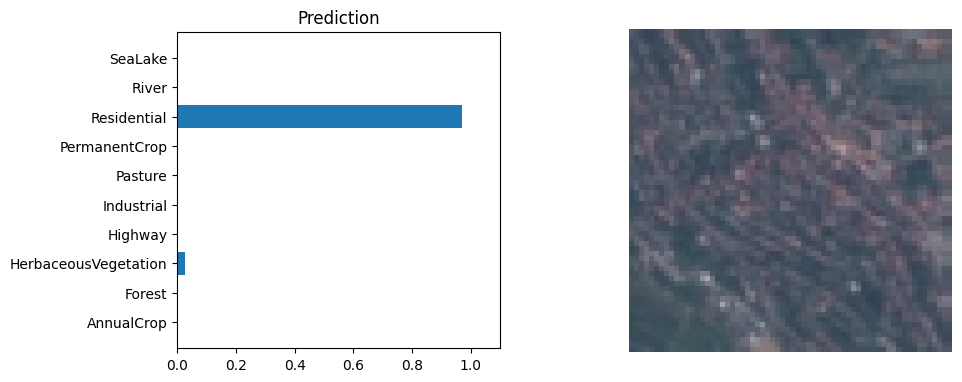

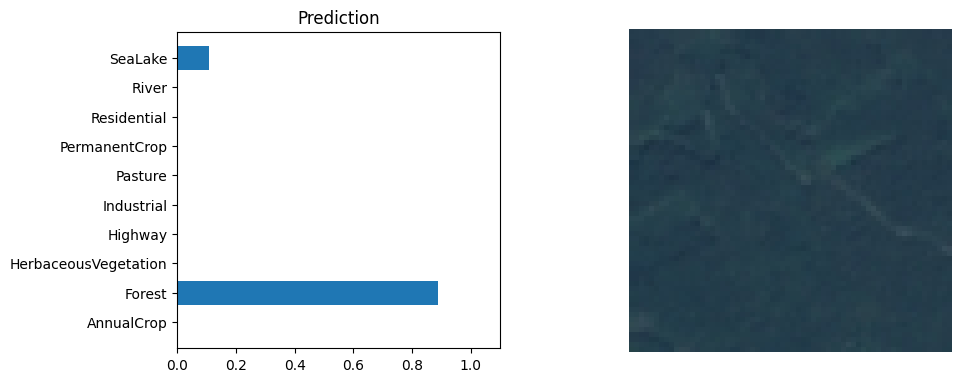

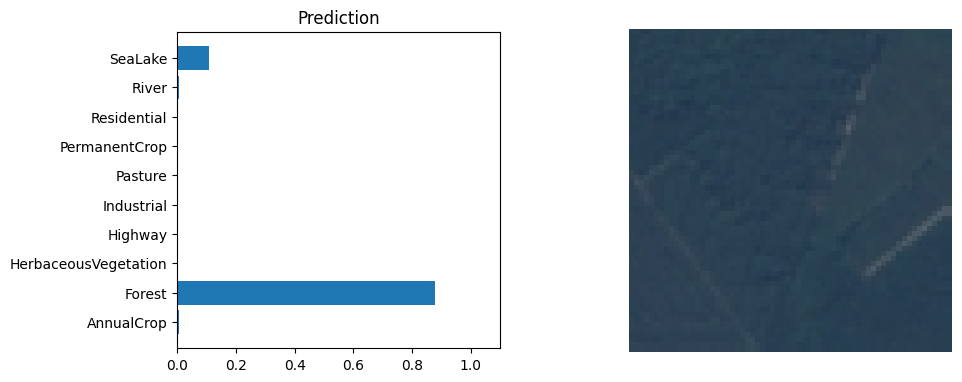

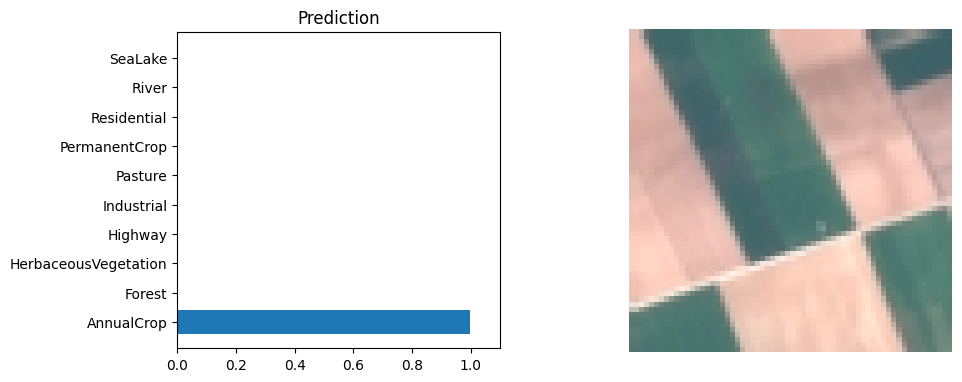

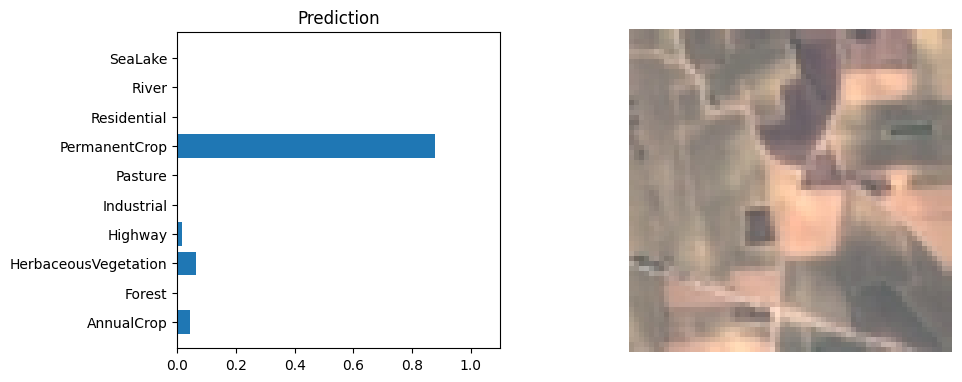

In [ ]:
images, _ = next(iter(test_loader))
preds = lenet.predict(images)

# Shows the image next to the classifier's softmax score
# Show for the first 5 images (change value to see more images)
for i in range(5):
    helpers.view_prediction(images[i], preds[i], dataset.classes)

## 3. Comparing networks

We've successfully trained two models on the EuroSAT dataset. But how do they differ? To find out, we'll compare their test accuracy and their architecture.

#### Test accuracy

In [ ]:
print("3-layer fully-connected net test accuracy:")
test(three_layer_net, test_loader)

3-layer fully-connected net test accuracy:


  0%|          | 0/85 [00:00<?, ?it/s]

Accuracy is 47.26%


In [ ]:
print("LeNet-5 test accuracy")
test(lenet, test_loader)

LeNet-5 test accuracy


  0%|          | 0/85 [00:00<?, ?it/s]

Accuracy is 74.78%


#### Model size

In [ ]:
torchsummary.summary(three_layer_net, (3, 64, 64), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1000]      12,289,000
            Linear-2                  [-1, 100]         100,100
            Linear-3                   [-1, 10]           1,010
Total params: 12,390,110
Trainable params: 12,390,110
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.01
Params size (MB): 47.26
Estimated Total Size (MB): 47.32
----------------------------------------------------------------


In [ ]:
torchsummary.summary(lenet, (3, 64, 64), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 18, 64, 64]           1,368
            Conv2d-2           [-1, 54, 28, 28]          24,354
            Linear-3                  [-1, 120]       1,270,200
            Linear-4                   [-1, 84]          10,164
            Linear-5                   [-1, 10]             850
Total params: 1,306,936
Trainable params: 1,306,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.89
Params size (MB): 4.99
Estimated Total Size (MB): 5.92
----------------------------------------------------------------


**Questions:**
- Which model has the highest accuracy?
- Compare the number of trainable parameters (weights) in both networks? Where do most of LeNet's trainable parameters come from?
- Which model takes longer to train? Look at the `it/s` metric displayed next to the progress bar.

**Answers:**
- LeNet performs better, as it reaches ~75% accuracy on EuroSAT, while the 3-layer FC net gets ~45% accuracy.
- Despite performing better, LeNet has much less trainable parameters than the 3 layer network. Also, notice that most of LeNet's weights come from the linear layers.
- On GPU, LeNet is faster to train (about 2x faster on our device).

In [ ]:
torch.save(lenet, 'lenet.pt')

Congratulations on finishing this exercise!

## (Optional) Additional PyTorch resources
- PyTorch basics: https://pytorch.org/tutorials/beginner/basics/intro.html
- PyTorch cheat sheet: https://pytorch.org/tutorials/beginner/ptcheat.html
- Other PyTorch tutorials: https://pytorch.org/tutorials/index.html
- PyTorch recipes: https://pytorch.org/tutorials/recipes/recipes_index.html (bite-sized code examples on specific PyTorch features)
- PyTorch examples: https://github.com/pytorch/examples